In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
535,4,132,0,0,0,32.9,0.302,23,1
231,6,134,80,37,370,46.2,0.238,46,1
150,1,136,74,50,204,37.4,0.399,24,0
722,1,149,68,29,127,29.3,0.349,42,1
281,10,129,76,28,122,35.9,0.280,39,0


In [ ]:
df.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df.shape

(768, 9)

**Train test split**

In [ ]:
X = df.drop('Outcome',axis='columns')
y = df['Outcome']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [ ]:
def monitor_class_distribution(y):
  class_distribution = np.bincount(y)
  if class_distribution[1]>class_distribution[0]:
    imbalance_ratio = class_distribution[1] / class_distribution[0]
  else:
    imbalance_ratio = class_distribution[0] / class_distribution[1]
  return imbalance_ratio

In [ ]:
imb_ratio=monitor_class_distribution(y)
print(imb_ratio)

1.8656716417910448


before applying sampling

In [ ]:
import time
import psutil
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

def train_resource_monitor(X_train, y_train):
  model= xgb.XGBClassifier(
      objective='binary:logistic',
      max_depth=3,
      learning_rate=0.1,
      n_estimators=100,
      subsample=0.8,
      colsample_bytree=0.8
  )
  cpu_usage = []
  memory_usage = []
  initial_cpu_percent = psutil.cpu_percent(interval=None)
  initial_memory_percent = psutil.virtual_memory().percent
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()
  execution_time = end_time - start_time
  final_cpu_percent = psutil.cpu_percent(interval=None)
  final_memory_percent = psutil.virtual_memory().percent
  size=len(y_train)
  print(f"Input size: {size}, Execution time: {execution_time:.6f} seconds")
  print(f"Initial CPU Usage: {initial_cpu_percent}%")
  print(f"Final CPU Usage: {final_cpu_percent}%")
  print(f"Initial Memory Usage: {initial_memory_percent}%")
  print(f"Final Memory Usage: {final_memory_percent}%")
  return model

In [ ]:
model1=train_resource_monitor(X_train, y_train)

Input size: 614, Execution time: 0.100020 seconds
Initial CPU Usage: 49.9%
Final CPU Usage: 84.2%
Initial Memory Usage: 10.4%
Final Memory Usage: 10.4%


In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds for cross-validation
def k_fold_validation(X_train,y_train,model):
  X_train = X_train.to_numpy()
  y_train = y_train.to_numpy()
  k=5
  kf=KFold(n_splits=k,shuffle=True,random_state=42)
  cv_scores=[]
  cv_rocs=[]
  for train_index,val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    model.fit(X_train_fold, y_train_fold)
    y_pred_val = model.predict(X_val_fold)
    y_prob_roc=model.predict_proba(X_val_fold)[:, 1]
    accuracy = accuracy_score(y_val_fold, y_pred_val)
    roc_auc=roc_auc_score(y_val_fold, y_prob_roc)
    cv_scores.append(accuracy)
    cv_rocs.append(roc_auc)
    print("Cross-validation scores:", cv_scores)
    print("Average cross-validation score:", np.mean(cv_scores))
    print("Cross-validation roc-auc:", cv_rocs)
    print("Average cross-validation roc-auc:", np.mean(cv_rocs))
    print('-----------------------------------------------------------------')

In [ ]:
k_fold_validation(X_train, y_train,model1)

Cross-validation scores: [0.7642276422764228]
Average cross-validation score: 0.7642276422764228
Cross-validation roc-auc: [0.8099397590361446]
Average cross-validation roc-auc: 0.8099397590361446
-----------------------------------------------------------------
Cross-validation scores: [0.7642276422764228, 0.7723577235772358]
Average cross-validation score: 0.7682926829268293
Cross-validation roc-auc: [0.8099397590361446, 0.7988505747126436]
Average cross-validation roc-auc: 0.804395166874394
-----------------------------------------------------------------
Cross-validation scores: [0.7642276422764228, 0.7723577235772358, 0.7804878048780488]
Average cross-validation score: 0.7723577235772359
Cross-validation roc-auc: [0.8099397590361446, 0.7988505747126436, 0.8531902879728966]
Average cross-validation roc-auc: 0.8206602072405617
-----------------------------------------------------------------
Cross-validation scores: [0.7642276422764228, 0.7723577235772358, 0.7804878048780488, 0.8130

In [ ]:
# Making predictions
y_pred = model1.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7467532467532467


In [ ]:
y_prob = model1.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.8068518518518518


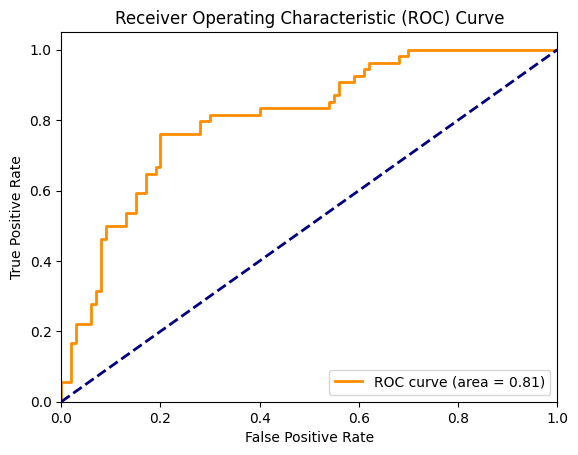

In [ ]:
# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       100
           1       0.69      0.50      0.58        54

    accuracy                           0.75       154
   macro avg       0.73      0.69      0.70       154
weighted avg       0.74      0.75      0.74       154



applying sampling

In [ ]:
X2 = df.drop('Outcome',axis='columns')
y2 = df['Outcome']

In [ ]:
print(X2.dtypes)

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object


In [ ]:
X2.shape, y2.shape

((768, 8), (768,))

In [ ]:
y2.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [ ]:
df.columns.tolist()

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [ ]:
import pandas as pd
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids

def adjust_sampling_parameters(X,y):
  # Apply KMeansSMOTE to the minority class
  kmeans_smote = KMeansSMOTE(sampling_strategy='auto', k_neighbors=8, cluster_balance_threshold=0.0)
  X_kmeans_smote, y_kmeans_smote = kmeans_smote.fit_resample(X, y)

  # Apply Cluster Centroids undersampling to the majority class
  cluster_centroids = ClusterCentroids(sampling_strategy='auto')
  X_cluster_centroids, y_cluster_centroids = cluster_centroids.fit_resample(X, y)

  # Concatenate the resampled data
  X_combined_resampled = np.concatenate((X_kmeans_smote, X_cluster_centroids), axis=0)
  y_combined_resampled = np.concatenate((y_kmeans_smote, y_cluster_centroids), axis=0)

  # Convert combined resampled data to DataFrame
  combined_df = pd.DataFrame(data=X_combined_resampled, columns=X.columns.tolist())
  combined_df['Class'] = y_combined_resampled
  return combined_df



In [ ]:
tolerance=0.2
def class_distribution_check(combined_df):
  X_combined = combined_df.drop('Class',axis='columns')
  y_combined = combined_df['Class']
  class_distribution=monitor_class_distribution(y_combined)
  while abs(class_distribution-1)>tolerance:
    #print(abs(class_distribution-1))
    combine_data=adjust_sampling_parameters(X_combined, y_combined)
    X_combined=combine_data.drop('Class',axis='columns')
    y_combined=combine_data['Class']
    class_distribution=monitor_class_distribution(y_combined)
  return X_combined, y_combined

In [ ]:
combined_df=adjust_sampling_parameters(X2,y2)
X_combined,y_combined=class_distribution_check(combined_df)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

In [ ]:
print((X_combined.shape))

(1543, 8)


In [ ]:
# Training the model
model2=train_resource_monitor(X_train, y_train)

Input size: 1234, Execution time: 0.359251 seconds
Initial CPU Usage: 41.0%
Final CPU Usage: 100.0%
Initial Memory Usage: 13.3%
Final Memory Usage: 13.3%


In [ ]:
k_fold_validation(X_train, y_train,model2)

Cross-validation scores: [0.8380566801619433]
Average cross-validation score: 0.8380566801619433
Cross-validation roc-auc: [0.9125984251968504]
Average cross-validation roc-auc: 0.9125984251968504
-----------------------------------------------------------------
Cross-validation scores: [0.8380566801619433, 0.8097165991902834]
Average cross-validation score: 0.8238866396761133
Cross-validation roc-auc: [0.9125984251968504, 0.9132177112074629]
Average cross-validation roc-auc: 0.9129080682021566
-----------------------------------------------------------------
Cross-validation scores: [0.8380566801619433, 0.8097165991902834, 0.8380566801619433]
Average cross-validation score: 0.8286099865047234
Cross-validation roc-auc: [0.9125984251968504, 0.9132177112074629, 0.9006039915966386]
Average cross-validation roc-auc: 0.9088067093336507
-----------------------------------------------------------------
Cross-validation scores: [0.8380566801619433, 0.8097165991902834, 0.8380566801619433, 0.817

In [ ]:
# Making predictions
y_pred = model2.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8122977346278317


In [ ]:
y_prob = model2.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9034903280067283


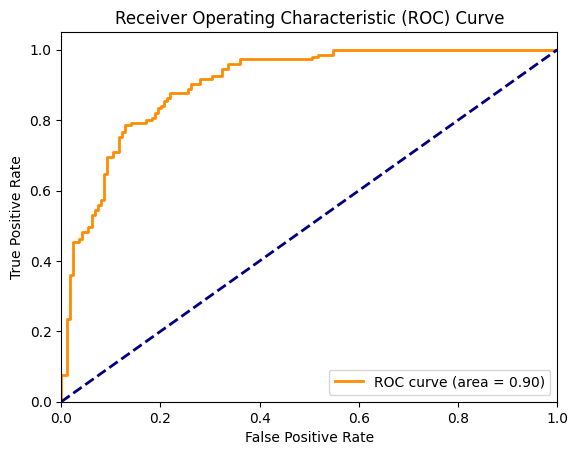

In [ ]:
# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       164
           1       0.79      0.81      0.80       145

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



In [ ]:
import pickle

# Assuming you have trained an XGBoost model named 'model'

# Save the model to a file
with open('xgboost_model_pima.pkl', 'wb') as f:
    pickle.dump(model2, f)

In [ ]:
import pickle

# Load the model from the file
with open('xgboost_model_pima.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
predictions = loaded_model.predict(X_test)

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       164
           1       0.79      0.81      0.80       145

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309

